# GMSL Analysis and Prediction

## Sea Level Rise Dataset (https://www.kaggle.com/nsidcorg/daily-sea-ice-extent-data)

Ovaj skup podataka sadrži ukupnu površina morskog leda za vremenski period od 1978. do 2015 godine.

Podaci koji su od interesa za naš rad su:

* Year - godina merenja
* Month - mesec merenja
* Day - dan merenja
* Extent - ukupna površina morskog leda izražena u jedinici 10^6 kvadratnih kilometar

In [1]:
import pandas as pd
import seaborn as sns
from scipy.optimize import curve_fit

In [2]:
df = pd.read_csv('original_datasets/seaice.csv', delimiter=',')

In [3]:
df.head()

,Year,Month,Day,Extent,Missing,Source Data,hemisphere
0,1978,10,26,10.231,0.0,['ftp://sidads.colorado.edu/pub/DATASETS/nsid...,north
1,1978,10,28,10.420,0.0,['ftp://sidads.colorado.edu/pub/DATASETS/nsid...,north
2,1978,10,30,10.557,0.0,['ftp://sidads.colorado.edu/pub/DATASETS/nsid...,north
3,1978,11,1,10.670,0.0,['ftp://sidads.colorado.edu/pub/DATASETS/nsid...,north
4,1978,11,3,10.777,0.0,['ftp://sidads.colorado.edu/pub/DATASETS/nsid...,north


In [4]:
df.columns

Index(['Year', ' Month', ' Day', '     Extent', '    Missing', ' Source Data',
       'hemisphere'],
      dtype='object')

In [5]:
df.drop(['    Missing', ' Source Data'], axis=1, inplace=True)

In [6]:
df.rename(columns={'     Extent':'Extent'}, inplace = True)

In [7]:
df.head()

,Year,Month,Day,Extent,hemisphere
0,1978,10,26,10.231,north
1,1978,10,28,10.420,north
2,1978,10,30,10.557,north
3,1978,11,1,10.670,north
4,1978,11,3,10.777,north


In [8]:
df['Year'] = pd.to_datetime(df[['Year', ' Month', ' Day']].astype(str).agg('-'.join, axis=1))

In [9]:
df.head()

,Year,Month,Day,Extent,hemisphere
0,1978-10-26,10,26,10.231,north
1,1978-10-28,10,28,10.420,north
2,1978-10-30,10,30,10.557,north
3,1978-11-01,11,1,10.670,north
4,1978-11-03,11,3,10.777,north


In [10]:
df.drop([' Month', ' Day'], axis=1, inplace=True)
#df['Date'] = pd.to_datetime(df['Date'])

In [11]:
df.rename(columns={'Year':'Date'}, inplace = True)

In [12]:
df.head()

,Date,Extent,hemisphere
0,1978-10-26,10.231,north
1,1978-10-28,10.420,north
2,1978-10-30,10.557,north
3,1978-11-01,10.670,north
4,1978-11-03,10.777,north


In [13]:
#df['Date'] = pd.to_datetime(df['Date'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26354 entries, 0 to 26353
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Date        26354 non-null  datetime64[ns]
 1   Extent      26354 non-null  float64       
 2   hemisphere  26354 non-null  object        
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 617.8+ KB


In [14]:
df.shape

(26354, 3)

In [15]:
df.describe()

,Extent
count,26354.000000
mean,11.494986
std,4.611734
min,2.080000
25%,7.601000
50%,12.217000
75%,15.114000
max,20.201000


In [16]:
df.isna().sum()

Date          0
Extent        0
hemisphere    0
dtype: int64

In [17]:
df.nunique()

Date          13177
Extent        13078
hemisphere        2
dtype: int64

#### Skup podataka ima 26354 redova, a duplikata ima 13177 iz razloga što za isti dan imamo zasebno zabeleženu debljinu leda na severnoj i južnoj hemisferi. Potrebno je da grupišemo podatke i izračunamo srednju vrednost.

In [18]:
duplicate_dates = df.duplicated(subset=['Date'], keep=False)
duplicate_dates
duplicate_dates_df = df.loc[duplicate_dates.values]
duplicate_dates_df.sort_values('Date').head(10)

,Date,Extent,hemisphere
0,1978-10-26,10.231,north
13177,1978-10-26,17.624,south
1,1978-10-28,10.420,north
13178,1978-10-28,17.803,south
2,1978-10-30,10.557,north
13179,1978-10-30,17.670,south
3,1978-11-01,10.670,north
13180,1978-11-01,17.527,south
4,1978-11-03,10.777,north
13181,1978-11-03,17.486,south


In [19]:
df.drop(['hemisphere'], axis=1, inplace=True)
df = df.groupby('Date').mean().reset_index()

In [20]:
df.shape

(13177, 2)

In [21]:
df.head()

,Date,Extent
0,1978-10-26,13.9275
1,1978-10-28,14.1115
2,1978-10-30,14.1135
3,1978-11-01,14.0985
4,1978-11-03,14.1315


In [22]:
df.nunique()

Date      13177
Extent     8344
dtype: int64

#### Sada smo dobili sve jedinstvene vrednosti datuma.

<AxesSubplot:xlabel='Extent'>

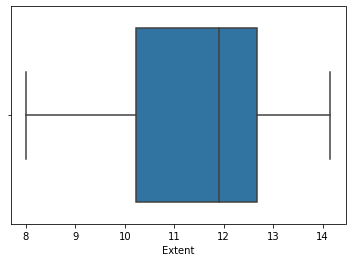

In [23]:
sns.boxplot(x=df['Extent'])

#### Proverili smo vrednosti i uočili da nema autlajera.

#### Uzimamo u obzir datume od 1969. do 2013. godine

In [24]:
df = df[(df['Date'] >= '1969-01') & (df['Date'] <= '2013-12')]

In [25]:
df.head().append(df.tail())

,Date,Extent
0,1978-10-26,13.9275
1,1978-10-28,14.1115
2,1978-10-30,14.1135
3,1978-11-01,14.0985
4,1978-11-03,14.1315
11165,2013-11-27,13.1905
11166,2013-11-28,13.1555
11167,2013-11-29,13.1335
11168,2013-11-30,13.0895
11169,2013-12-01,13.0660


#### Dodajemo datume koji nedostaju

In [26]:
df.set_index('Date', inplace = True)

In [27]:
idx = pd.date_range(start='1969-01', end='1978-10' , freq='M')
df_missing = df.reindex(idx, fill_value=None)

df = df_missing.append(df)

In [28]:
df.reset_index(inplace = True)

In [29]:
df.rename(columns={'index':'Date'}, inplace = True)

In [30]:
df['Date'] = pd.to_datetime(df['Date'])

In [31]:
df['Date'] = df['Date'].dt.strftime('%Y-%m')

#### Obzirom da nam kod datuma dani nisu neophodni, potrebno je grupisati podatke po mesecima.

In [32]:
df = df.groupby('Date').mean().reset_index()

In [33]:
df.head().append(df.tail())

,Date,Extent
0,1969-01,NaN
1,1969-02,NaN
2,1969-03,NaN
3,1969-04,NaN
4,1969-05,NaN
535,2013-08,12.338645
536,2013-09,12.298467
537,2013-10,13.236306
538,2013-11,13.405600
539,2013-12,13.066000


In [34]:
# Function to curve fit to the data
def func(x, a, b, c, d):
    return a * (x ** 3) + b * (x ** 2) + c * x + d

In [35]:
# Initial parameter guess, just to kick off the optimization
guess = (11.5, 11.5, 11.5, 11.5)

In [36]:
# Create copy of data to remove NaNs for curve fitting
fit_df = df.dropna()

In [37]:
# Curve fit each column
col_params = {}
# for col in fit_df.columns:
# Get x & y
x = fit_df.index.astype(float).values
y = fit_df['Extent'].values
# Curve fit column and get curve parameters
params = curve_fit(func, x, y, guess)
# Store optimized parameters
col_params['Extent'] = params[0]

In [38]:
# Extrapolate each column
# for col in df.columns:
# Get the index values for NaNs in the column
x = df[pd.isnull(df['Extent'])].index.astype(float).values
# Extrapolate those points with the fitted function
df['Extent'][x] = func(x, *col_params['Extent'])

C:\Users\Stefan\AppData\Local\Temp/ipykernel_8672/3406352447.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Extent'][x] = func(x, *col_params['Extent'])
C:\Users\Stefan\anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [39]:
df.head().append(df.tail())

,Date,Extent
0,1969-01,11.412998
1,1969-02,11.419180
2,1969-03,11.425310
3,1969-04,11.431388
4,1969-05,11.437415
535,2013-08,12.338645
536,2013-09,12.298467
537,2013-10,13.236306
538,2013-11,13.405600
539,2013-12,13.066000


In [1168]:
df.to_csv('processed_datasets/Extent.csv', index = False)